<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/adv_01_dialated_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
- implement a dialated Convolutions
- link: https://arxiv.org/pdf/1609.03499

In [1]:
#BOILERPLATE CONVNET
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-11 10:32:01--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2025-07-11 10:32:01 (8.88 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

words = open('names.txt', 'r').read().splitlines()

# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)


# build the dataset
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Using device: cuda
torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [4]:
class EmbeddingWithReshape(nn.Module):
  def __init__(self, vocab_size, n_embd):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, n_embd)
  """
  Use transpose to rearrange dimensions.
  View wont work unless the tensor is already in the correct memory layout.
  Usefull link: https://blog.ezyang.com/2019/05/pytorch-internals/
  """
  def forward(self, x):
    # x: (B, T)
    x = self.embedding(x) # (B,T,C)
    x = x.transpose(1, 2) # (B,C,T)
    return x

In [ ]:
n_embd = 10
n_hidden = 20
block_size = 8

model = nn.Sequential(
    EmbeddingWithReshape(vocab_size, n_embd),
    nn.Conv1d(n_embd, n_hidden, kernel_size=2),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    nn.Conv1d(n_hidden, n_hidden, kernel_size=2),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    nn.Conv1d(n_hidden, n_hidden, kernel_size=2),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(n_hidden, vocab_size),
)

x = torch.randint(0, vocab_size, (32, block_size))
print(f"Input shape: {x.shape}")

for layer in model:
    x = layer(x)
    print(f"{layer.__class__.__name__}: {x.shape}")

Input shape: torch.Size([32, 8])
EmbeddingWithReshape: torch.Size([32, 10, 8])
Conv1d: torch.Size([32, 20, 7])
BatchNorm1d: torch.Size([32, 20, 7])
Tanh: torch.Size([32, 20, 7])
Conv1d: torch.Size([32, 20, 6])
BatchNorm1d: torch.Size([32, 20, 6])
Tanh: torch.Size([32, 20, 6])
Conv1d: torch.Size([32, 20, 5])
BatchNorm1d: torch.Size([32, 20, 5])
Tanh: torch.Size([32, 20, 5])
AdaptiveAvgPool1d: torch.Size([32, 20, 1])
Flatten: torch.Size([32, 20])
Linear: torch.Size([32, 27])


In [ ]:
parameters = list(model.parameters())
print(f"Parameters: {sum((p.nelement() for p in parameters))}")

Parameters: 3017


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3641


In [ ]:
# BOILERPLATE END

# What is a dialted Convolution?
- A dialted convolution introduces gaps between kernel elements. In 1D, this means the filter covers a wider range of input elements without increasing the number of parameters.

- main idea: each layer covers a sparse pattern, but the full network sees a dense pattern

# Kernel Example
  - Input : x0 x1 x2 x3 x4 x5 x6
  - Conv-k : x0 x1 x2
  - dConv-k: x0    x2    x4

# Layer example
## Model L0 d=1 -> L1 d=2 -> L2 d=4

- Standard convolution/Dialation 1
- [x0, x1, x2] → y0
- [x1, x2, x3] → y1
- [x2, x3, x4] → y2
- [x3, x4, x5] → y3
- [x4, x5, x6] → y4

- Dialation = 2
- [x0,   x2,   x4] → z0
- [x1,   x3,   x5] → z1
- [x2,   x4,   x6] → z2

- Dialation = 4
- [x0, x4, --] → w0
- [x1, x5, --] → w1

# Summary of Coverage
- x0   | L0, L1, L2
- x1   | L0, L1, L2
- x2   | L0, L1
- x3   | L0, L1
- x4   | L0, L1, L2
- x5   | L0, L1, L2
- x6   | L0, L1

- --> Dialted convolutions skip information, but stacking them with increasing dialation lets the network:
  - Cover all inputs
  - See both local nad global context
  - grow the receptive field exponentially

# The gensis of Dialted Convolution
- Goal is to build it up from toy examples, to understand it all.



In [ ]:
import torch

x = torch.tensor([0., 1., 2., 3., 4., 5., 6.])
kernel = torch.tensor([1., 10., 100.])

output = []

for t in range(x.shape[0] - kernel.shape[0] + 1):  # (T - K + 1)
    window = x[t:t+3]
    conv = (window * kernel).sum()
    output.append(conv.item())

# Problem output shrink
print("Standard convolution output:")
print(output)

Standard convolution output:
[210.0, 321.0, 432.0, 543.0, 654.0]


In [ ]:
dilation = 2
output = []

for t in range(x.shape[0] - dilation*2):
  i0 = t
  i1 = t + dilation
  i2 = t + 2*dilation
  window = torch.stack([x[i0], x[i1], x[i2]])
  conv = (window * kernel).sum()
  output.append(conv.item())

print("\nDilated convolution (d=2) output:")
print(output)


Dilated convolution (d=2) output:
[420.0, 531.0, 642.0]


In [ ]:
x = torch.tensor([0., 1., 2., 3., 4., 5., 6.])
kernel = torch.tensor([1., 10., 100.])

def dilated_conv_1d_same(x, kernel, dilation):
    K = kernel.shape[0]
    pad = dilation * ((K - 1) // 2)
    x_padded = torch.nn.functional.pad(x, (pad, pad))

    output = []

    for t in range(x.shape[0]):
        i0 = t
        i1 = t + dilation
        i2 = t + 2 * dilation
        if i2 >= x_padded.shape[0]:
            break  # prevent out-of-bounds
        window = torch.stack([
            x_padded[i0],
            x_padded[i1],
            x_padded[i2],
        ])
        conv = (window * kernel).sum()
        output.append(conv.item())
    return torch.tensor(output)

# Layer 0: dilation=1
y0 = dilated_conv_1d_same(x, kernel, dilation=1)
print(f"L0 (d=1): {y0}")
print(f"L0 element: {y0.shape}")

# Layer 1: dilation=2
y1 = dilated_conv_1d_same(y0, kernel, dilation=2)
print(f"L1 (d=2): {y1}")
print(f"L1 element: {y1.shape}")

# Layer 2: dilation=4
y2 = dilated_conv_1d_same(y1, kernel, dilation=4)
print(f"L2 (d=4): {y2}")
print(f"L2 element: {y2.shape}")


L0 (d=1): tensor([100., 210., 321., 432., 543., 654.,  65.])
L0 element: torch.Size([7])
L1 (d=2): tensor([33100., 45300., 57610., 69930., 12251.,  6972.,  1193.])
L1 element: torch.Size([7])
L2 (d=4): tensor([1556100., 1150200.,  695400.,  699300.,  155610.,  115020.,   69540.])
L2 element: torch.Size([7])


In [5]:
# Pytroch implementation
class DialatedConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, dilation):
    super().__init__()
    self.kernel_size = kernel_size
    self.padding = dilation * (kernel_size - 1)
    self.conv = nn.Conv1d(
        in_channels,
        out_channels,
        kernel_size,
        dilation=dilation
    )

  def forward(self, x):
    # Pad left side only.
    x = F.pad(x, (self.padding, 0))
    return self.conv(x)

In [6]:
n_embd = 10
n_hidden = 200
block_size = 8

model = nn.Sequential(
    EmbeddingWithReshape(vocab_size, n_embd),
    DialatedConvolution(n_embd, n_hidden, kernel_size=2, dilation=1),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    DialatedConvolution(n_hidden, n_hidden, kernel_size=2, dilation=2),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    DialatedConvolution(n_hidden, n_hidden, kernel_size=2, dilation=4),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(n_hidden, vocab_size),
)

model = model.to(device)

In [7]:
parameters = list(model.parameters())
print(f"Parameters: {sum((p.nelement() for p in parameters))}")

Parameters: 171497


## Adding accuracy
### What is Accuracy?
1. Take the logits
2. convert them into predicted class: argmax(dim=1)
3. Compare those to the true labels (preds == targets)
4. Count how many were correct, and divide by batch size.

## Adding Entropy
### for the models output distribution
- Show condfidence or uncertainy
- Overly confidet = peaky softmax
1. single softmax output = p = softmax(logits)
2. H(p) = - (sum of p * log(p))
3. Results:
  - low entropy = very confident (close to one-hot)
  - high entropy = uncertain (more uniform)


# Interpretation
1. Decreasing entropy + incresing accuracy = good learning
2. Entropy too low early = overcondifence, maybe overfitting
3. Entropy stalls or increases = model might be confused or learning nothing

## Anaology:
- A confident student (low entropy) might be wrong — high loss.
- A guessing student (high entropy) might get it right by chance — low loss (rarely).

In [8]:
def split_loss(split):
  model.eval()
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  with torch.no_grad():
    x = x.to(device)
    y = y.to(device)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean()

    probs = F.softmax(logits, dim=1)
    log_probs = torch.log(probs + 1e-9)
    entropy = -(probs * log_probs).sum(dim=1).mean()
  return loss, acc, entropy

In [9]:
max_steps = 200000
batch_size = 32
tr_loss_his, dev_loss_his = [], []
tr_acc_his, dev_acc_his = [], []
train_entropy_his, dev_entropy_his = [], []

for i in range(max_steps):
  model.train()
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix].to(device), Ytr[ix].to(device)

  # forward pass
  logits = model(Xb)
  train_loss = F.cross_entropy(logits, Yb)

  # accuracy
  preds = torch.argmax(logits, dim=1)
  train_acc = (preds == Yb).float().mean()

  # logits: (batch_size, vocab_size)
  probs = F.softmax(logits, dim=1)                    # (B, C)
  log_probs = torch.log(probs + 1e-9)                 # prevent log(0)
  entropy = -(probs * log_probs).sum(dim=1).mean()    # average over batch


  # backward pass
  for p in parameters:
    p.grad = None

  train_loss.backward()

  # update
  lr = 0.1 if i < 120000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  with torch.no_grad():
    dev_loss, dev_acc, dev_entropy = split_loss('val')

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d} - Train loss: {train_loss.item():.4f} Acc: {train_acc:.4f} | Val loss: {dev_loss.item():.4f} Acc: {dev_acc:.4f}')

  tr_loss_his.append(train_loss.log10().item())
  dev_loss_his.append(dev_loss.log10().item())
  tr_acc_his.append(train_acc.log10().item())
  dev_acc_his.append(dev_acc.log10().item())
  train_entropy_his.append(entropy.item())
  dev_entropy_his.append(dev_entropy.item())

      0/ 200000 - Train loss: 3.3092 Acc: 0.0938 | Val loss: 3.2812 Acc: 0.1410
  10000/ 200000 - Train loss: 2.3880 Acc: 0.3750 | Val loss: 2.2073 Acc: 0.3210
  20000/ 200000 - Train loss: 1.8099 Acc: 0.4062 | Val loss: 2.1380 Acc: 0.3396
  30000/ 200000 - Train loss: 2.2675 Acc: 0.3750 | Val loss: 2.1298 Acc: 0.3315
  40000/ 200000 - Train loss: 1.8833 Acc: 0.4062 | Val loss: 2.0896 Acc: 0.3484
  50000/ 200000 - Train loss: 2.2941 Acc: 0.3125 | Val loss: 2.0806 Acc: 0.3557
  60000/ 200000 - Train loss: 1.8314 Acc: 0.4062 | Val loss: 2.0574 Acc: 0.3590
  70000/ 200000 - Train loss: 2.1294 Acc: 0.3438 | Val loss: 2.0530 Acc: 0.3603
  80000/ 200000 - Train loss: 1.8876 Acc: 0.4062 | Val loss: 2.0484 Acc: 0.3629
  90000/ 200000 - Train loss: 1.8338 Acc: 0.3750 | Val loss: 2.0579 Acc: 0.3629
 100000/ 200000 - Train loss: 2.0883 Acc: 0.2812 | Val loss: 2.0361 Acc: 0.3631
 110000/ 200000 - Train loss: 1.8197 Acc: 0.4062 | Val loss: 2.0342 Acc: 0.3638
 120000/ 200000 - Train loss: 1.8909 Acc

In [10]:
# convert to tensors
tr_loss_t = torch.tensor(tr_loss_his)
dev_loss_t = torch.tensor(dev_loss_his)
tr_acc_t  = torch.tensor(tr_acc_his)
dev_acc_t = torch.tensor(dev_acc_his)

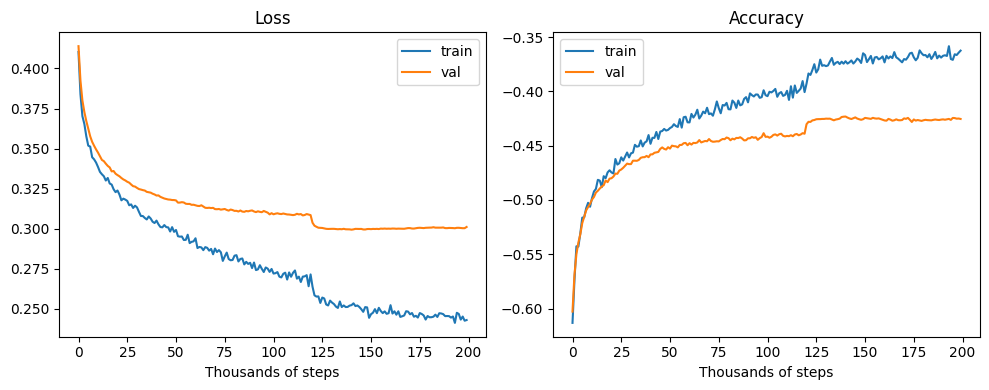

In [11]:
chunk = 1000
tr_loss_smooth = tr_loss_t.view(-1, chunk).mean(1)
dev_loss_smooth = dev_loss_t.view(-1, chunk).mean(1)
tr_acc_smooth = tr_acc_t.view(-1, chunk).mean(1)
dev_acc_smooth = dev_acc_t.view(-1, chunk).mean(1)

# plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(tr_loss_smooth, label='train')
plt.plot(dev_loss_smooth, label='val')
plt.title('Loss')
plt.xlabel('Thousands of steps')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tr_acc_smooth, label='train')
plt.plot(dev_acc_smooth, label='val')
plt.title('Accuracy')
plt.xlabel('Thousands of steps')
plt.legend()

plt.tight_layout()
plt.show()

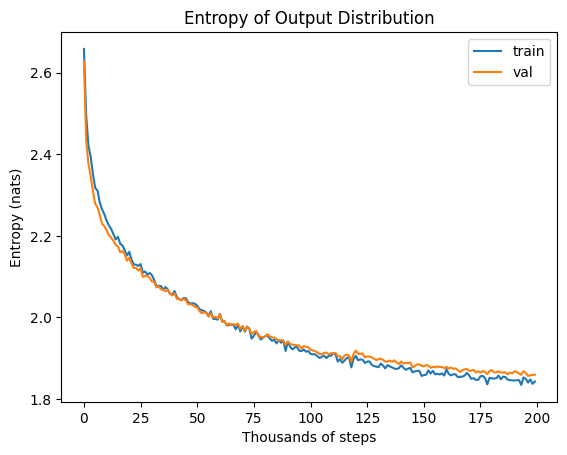

In [12]:
train_ent = torch.tensor(train_entropy_his).view(-1, 1000).mean(1)
val_ent = torch.tensor(dev_entropy_his).view(-1, 1000).mean(1)

plt.plot(train_ent, label='train')
plt.plot(val_ent, label='val')
plt.title('Entropy of Output Distribution')
plt.xlabel('Thousands of steps')
plt.ylabel('Entropy (nats)')
plt.legend()
plt.show()

In [13]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size
    context = torch.tensor([context], dtype=torch.long).to(device)
    while True:
      logits = model(context)
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      out.append(ix)
      # shift the context window and track the samples
      context = torch.cat([context[:, 1:], torch.tensor([[ix]], device=device)], dim=1)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mariol.
kinslee.
hazley.
yademileon.
lanshi.
luksa.
kahla.
nishtam.
tylah.
aakiah.
deszel.
jaleia.
laurynn.
lolli.
faload.
delyse.
trewsno.
arnim.
aalyah.
roshey.
